# Keyword Detection on Websites

## Objective 
+ Create an algorithm, that takes html page as input and infers if the page contains the information about cancer tumorboard or not

## What is a tumor board?
+ Tumor Board is a consilium of doctors (usually from different disciplines) discussing cancer cases in their departments

### Initial Steps

+ Read in test, train and keyword csv's
+ Prepare to use beautiful soup to parse the HTML content needed
+ Install lxml, an HMTL parser

In [1]:
# importing packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# reading in training csv
train_df = pd.read_csv('detection_train.csv')

# printing out 10 random samples from the dataset
train_df.sample(n = 10, random_state = 42)

,url,doc_id,label
83,http://www.sbk-vs.de/de/medizin/leistungen-und...,125,1
53,http://www.klinikum-esslingen.de/kliniken-und-...,85,2
70,http://www.malteser-kliniken-rhein-ruhr.de/med...,107,2
45,http://www.klilu.de/medizin__pflege/kliniken_u...,73,2
44,http://www.kk-bochum.de/de/kliniken_zentren_be...,72,1
39,http://www.gesundheit-nordhessen.de/klinikum-k...,57,3
22,http://stereotaxie.uk-koeln.de/erkrankungen-th...,28,2
80,http://www.neurochirurgie.uk-erlangen.de/forsc...,120,1
10,http://krebszentrum.kreiskliniken-reutlingen.d...,13,2
0,http://elbe-elster-klinikum.de/fachbereiche/ch...,1,1


In [2]:
# reading in training csv
test_df = pd.read_csv('detection_test.csv')

# printing out 10 random samples from the dataset
test_df.sample(n = 10, random_state = 42)

,url,doc_id
27,http://www.josephstift-dresden.de/pressemittei...,71
40,http://www.pius-hospital.de/kliniken/gynaekolo...,123
26,http://www.interdisziplinaere-endoskopie.mri.t...,70
43,http://www.uk-augsburg.de/krebsbehandlung/diag...,134
24,http://www.hjk-muenster.de/unsere-kompetenzen/...,68
37,http://www.maria-josef-hospital.de/unsere-komp...,109
12,http://www.ctk.de/klinikum/karriere/stellenang...,46
19,http://www.gesundheitszentrum-wetterau.de/342/...,59
4,http://marienhospital-buer.de/mhb-av-chirurgie...,16
25,http://www.hufeland.de/de/abteilung-fuer-gastr...,69


In [3]:
# reading in training csv
keyword_df = pd.read_csv('keyword2tumor_type.csv')

# printing out 10 random samples from the dataset
keyword_df.sample(n = 10, random_state = 42)

,keyword,tumor_type
73,magen,Magen
19,malignome,Endokrine malignome
116,molekulare,Molekular
67,transit,Lymphom
94,bone,Sarkome
77,mammographie,Mamma carcinoma
31,gynäkologische,Gynäkologie
53,thyroid,Kopf-hals
117,oral,Oral
44,lympho,Hämatooncology


In [4]:
# now let's understand the distribution of labels across the training doc

train_df['label'].value_counts().reset_index()

,index,label
0,2,59
1,1,32
2,3,9


### Next steps

+ Load the data to read the HTML files
+ Create a function that will load the corresponding HTML file from the htmls directory
+ Get the HMTL contents and store it in a new column called "html"
+ Since the documents are in German, the encoding cannot be utf-8 which is commonly used, instead latin1 will be used

In [5]:
# defining a function to read an HMTL file given a document ID
def read_html(doc_id: int) -> str:
    # open the HTML file with the given document ID
    with open(file=f"htmls/{doc_id}.html",
              mode="r",
              encoding="latin1") as f:
        # read the contents of the file and store it as a string
        html = f.read()
    # return the HMTL string    
    return html


# apply the read_html function to each value in the "doc_id" column of the train_df dataframe
# and store the resulting HTML strings in a new column called "html"
train_df["html"] = train_df["doc_id"].apply(read_html)

In [6]:
train_df.sample(n = 10, random_state = 42)

,url,doc_id,label,html
83,http://www.sbk-vs.de/de/medizin/leistungen-und...,125,1,"\n\n<!DOCTYPE HTML>\n<html dir=""ltr"" lang=""de_..."
53,http://www.klinikum-esslingen.de/kliniken-und-...,85,2,"<!DOCTYPE html>\n<html xmlns=""http://www.w3.or..."
70,http://www.malteser-kliniken-rhein-ruhr.de/med...,107,2,"<!DOCTYPE html>\n<html lang=""de"">\n<head>\n\n<..."
45,http://www.klilu.de/medizin__pflege/kliniken_u...,73,2,"<!DOCTYPE html>\n<html lang=""de""><head>\n\t<me..."
44,http://www.kk-bochum.de/de/kliniken_zentren_be...,72,1,"<!DOCTYPE html PUBLIC ""-//W3C//DTD HTML 4.01 T..."
39,http://www.gesundheit-nordhessen.de/klinikum-k...,57,3,"<!DOCTYPE html>\n<!--[if lt IE 7 ]><html dir=""..."
22,http://stereotaxie.uk-koeln.de/erkrankungen-th...,28,2,"<!DOCTYPE html> <html class=""no-js""> <head> <m..."
80,http://www.neurochirurgie.uk-erlangen.de/forsc...,120,1,"<!DOCTYPE html>\n<html class=""no-js"">\n<meta h..."
10,http://krebszentrum.kreiskliniken-reutlingen.d...,13,2,"<!DOCTYPE html PUBLIC ""-//W3C//DTD XHTML 1.0 T..."
0,http://elbe-elster-klinikum.de/fachbereiche/ch...,1,1,<!DOCTYPE html>\n<!-- jsn_reta_pro 1.0.2 -->\n...


### Parsing the HTML Content

+ Use the package BeautifulSoup to parse through the HTML content for the data we need
+ On top of BeautifulSoup, we will use the a proper HMTL parser, which is the lxml library
+ Build a function that extracts the text

In [7]:
import warnings

from bs4 import BeautifulSoup

# filtering warning messages
warnings.filterwarnings(action = "ignore")

# defining a function to extract text from HTML
def extract_html(html: str) -> str:
    # creating a beautiful soup object and parsing the HTML
    bs = BeautifulSoup(markup = html, features = 'lxml')
    # removing script and style tags
    for script in bs(name = ['script', 'style']):
        script.decompose()
    # getting the text content after removing script style tags
    return bs.get_text(separator = "")

# applying the extract html function to the html column
train_df['html_text'] = train_df['html'].apply(extract_html)

In [8]:
# displaying the dataframe to ensure the function worked appropriately
train_df.sample(n = 10, random_state = 42)

,url,doc_id,label,html,html_text
83,http://www.sbk-vs.de/de/medizin/leistungen-und...,125,1,"\n\n<!DOCTYPE HTML>\n<html dir=""ltr"" lang=""de_...",\n\n\n\n\nProstata-Karzinom-Zentrum - Schwarzw...
53,http://www.klinikum-esslingen.de/kliniken-und-...,85,2,"<!DOCTYPE html>\n<html xmlns=""http://www.w3.or...",\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...
70,http://www.malteser-kliniken-rhein-ruhr.de/med...,107,2,"<!DOCTYPE html>\n<html lang=""de"">\n<head>\n\n<...",\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...
45,http://www.klilu.de/medizin__pflege/kliniken_u...,73,2,"<!DOCTYPE html>\n<html lang=""de""><head>\n\t<me...",\n\n\n\nDarmzentrum Rheinpfalz » Zentren A-Z »...
44,http://www.kk-bochum.de/de/kliniken_zentren_be...,72,1,"<!DOCTYPE html PUBLIC ""-//W3C//DTD HTML 4.01 T...",\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...
39,http://www.gesundheit-nordhessen.de/klinikum-k...,57,3,"<!DOCTYPE html>\n<!--[if lt IE 7 ]><html dir=""...",\n\n\n\n\n\nInterdisziplinÃ¤re Zusammenarbeit ...
22,http://stereotaxie.uk-koeln.de/erkrankungen-th...,28,2,"<!DOCTYPE html> <html class=""no-js""> <head> <m...",Radiochirurgie - Hirntumore - Erkrank...
80,http://www.neurochirurgie.uk-erlangen.de/forsc...,120,1,"<!DOCTYPE html>\n<html class=""no-js"">\n<meta h...",\n\n\n\n\nNeurochirurgie\n\n\n\n\n\n\n\n\n\n\n...
10,http://krebszentrum.kreiskliniken-reutlingen.d...,13,2,"<!DOCTYPE html PUBLIC ""-//W3C//DTD XHTML 1.0 T...",\n\n\nKrebszentrum Reutlingen: Zentrale Einric...
0,http://elbe-elster-klinikum.de/fachbereiche/ch...,1,1,<!DOCTYPE html>\n<!-- jsn_reta_pro 1.0.2 -->\n...,\n\n\n\n\n\nElbe-Elster Klinikum - Chirurgie F...


### Next Steps

+ The HTML text has been extracted but it contrains a lot of new line symbols (\n)
+ In order to remove these characters from the html_text, the text must be cleaned or preprocessed
+ Since we are looking to keyword detections, remove any other unnecessary characters
+ Write a function to remove non-alphanumeric characters, multiple whitespaces and numerical characters
+ We will also remove any stop words

### How the function will work in steps

1. Strips all non-alphanumerical characters
2. Strips all multiple whitespaces
3. Strips all punctuation
4. Strips all numerical characters
5. Converts to lowercase and then stems the text
6. Removes all stop-words

### What does stop words mean?

+ Stop words are common words that occur frequently in a language, but are not very informative or meaningful for natural language processing tasks. Examples of stop words in English include words like "the", "a", "an", "and", "in", "of", "to", etc

### Once that is completed

+ Once the chracters aforementioned are removed, the next step is to perform an Exploratory Data Analysis of the dataset

In [9]:
import re
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords

def preprocess_html_text(html_text: str) -> str:
    stemmer = SnowballStemmer("english")         # initializing Snowball stemmer for English language
    stop_words = stopwords.words('english')      # getting english stop words
    text = html_text.lower()                     # converting the text to lower case
    text = re.sub(r'\W', ' ', text)              # replace non-alphanumeric characters with whitespace
    text = re.sub(r'\s+', ' ', text)             # # replace multiple whitespaces with single whitespace
    text = re.sub(r'\d+', '', text)              # # remove numerical characters
    tokens = text.split()                        # splitting and tokenizing the text
    tokens = [stemmer.stem(token) for token in tokens if token not in stop_words]  # apply stemming and remove stop words through a list comprehension
    return " ".join(tokens)                      # join the tokens back together to form the preprocessed text

# applying function to the html_text column and storing the preprocessed text in a new column
train_df['preprocessed_text'] = train_df['html_text'].apply(preprocess_html_text)

In [10]:
# displaying dataframe to ensure the preprocessing was successful
train_df.sample(n = 5, random_state = 42)

,url,doc_id,label,html,html_text,preprocessed_text
83,http://www.sbk-vs.de/de/medizin/leistungen-und...,125,1,"\n\n<!DOCTYPE HTML>\n<html dir=""ltr"" lang=""de_...",\n\n\n\n\nProstata-Karzinom-Zentrum - Schwarzw...,prostata karzinom zentrum schwarzwald baar kli...
53,http://www.klinikum-esslingen.de/kliniken-und-...,85,2,"<!DOCTYPE html>\n<html xmlns=""http://www.w3.or...",\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,unser profil gefã ã und thoraxchirurgi kliniku...
70,http://www.malteser-kliniken-rhein-ruhr.de/med...,107,2,"<!DOCTYPE html>\n<html lang=""de"">\n<head>\n\n<...",\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,maltes kliniken rhein ruhr darmzentrum duisbur...
45,http://www.klilu.de/medizin__pflege/kliniken_u...,73,2,"<!DOCTYPE html>\n<html lang=""de""><head>\n\t<me...",\n\n\n\nDarmzentrum Rheinpfalz » Zentren A-Z »...,darmzentrum rheinpfalz zentren z kliniken und ...
44,http://www.kk-bochum.de/de/kliniken_zentren_be...,72,1,"<!DOCTYPE html PUBLIC ""-//W3C//DTD HTML 4.01 T...",\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,mund kiefer und plastisch gesichtschirurgi de ...


## Exploratory Data Analysis

#### Questions to address

+ What is the average length of characters per text? 
+ What about average amount of words per text?
+ Since we are building a model to detect key words, unique words are important. What does that distribution look like?


#### Takeaways 

+ Are there any outliers?
+ Can we draw assumptions on the data by looking at some visuals?

#### Approach

+ Apply the .len function to preprocessed text to count the total number of characters per article and store it in a new column
+ Use the 'str' accessor to split the text directly and applying the .len function to calculate numbers of words per article and store it in a new column

In [11]:
# importing plotly
import plotly.express as px
import plotly.offline as pyo

# set notebook mode to work in offline
pyo.init_notebook_mode(connected=True)

In [12]:
# adding a new column counting the total number of characters
train_df['character count'] = train_df['preprocessed_text'].apply(len)

# also adding a new column counting to the total number of words in each article
train_df['word count'] = train_df['preprocessed_text'].str.split().apply(len)

# adding in unique words per article as well
train_df['unique word count'] = train_df['preprocessed_text'].str.split().apply(set).apply(len)

# displaying the dataframe to ensure it worked
train_df

,url,doc_id,label,html,html_text,preprocessed_text,character count,word count,unique word count
0,http://elbe-elster-klinikum.de/fachbereiche/ch...,1,1,<!DOCTYPE html>\n<!-- jsn_reta_pro 1.0.2 -->\n...,\n\n\n\n\n\nElbe-Elster Klinikum - Chirurgie F...,elb elster klinikum chirurgi finsterwald suche...,8326,960,473
1,http://klinikum-bayreuth.de/einrichtungen/zent...,3,3,"<!DOCTYPE html>\n<html class=""no-js"" lang=""de""...",\n\n\n\n\n\n\nOnkologisches Zentrum - Klinikum...,onkologisch zentrum klinikum bayreuth aktuel ã...,22752,2742,926
2,http://klinikum-braunschweig.de/info.php/?id_o...,4,1,"<!doctype html>\n<html lang=""de"">\n<head>\n\t<...",\n\nZentrum - SozialpÃ¤diatrisches Zentrum - S...,zentrum sozialpã diatrisch zentrum stã dtisch ...,9021,1062,529
3,http://klinikum-braunschweig.de/info.php/?id_o...,5,1,"<!doctype html>\n<html lang=""de"">\n<head>\n\t<...",\n\nLeistung - Spezielle UnterstÃ¼tzung bei de...,leistung speziell unterstã¼tzung bei der anmel...,4052,414,252
4,http://klinikum-braunschweig.de/zuweiser/tumor...,6,3,"<!doctype html>\n<html lang=""de"">\n<head>\n\t<...",\n\nZuweiser - Tumorkonferenzen - Tumorkonfere...,zuweis tumorkonferenzen tumorkonferenz gastroi...,4378,434,219
...,...,...,...,...,...,...,...,...,...
95,http://www.unicross.uni-freiburg.de/thema/unifm/,140,1,"<!DOCTYPE html>\n<html lang=""de-DE""\nprefix=""o...",\n\n\n\n\n\n\n\n\n\n\nuniFM | uniCROSS\n\n\n\n...,unifm unicross news magazin theme home wir mac...,176782,27209,6904
96,http://www.uniklinik-duesseldorf.de/patienten-...,141,1,"<!DOCTYPE html>\n<html class=""no-js"" lang=""de""...",\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nInterdis...,interdisziplinã neurovaskulã konferenz ǀ ukd j...,7046,835,452
97,http://www.vivantes.de/fuer-sie-vor-ort/klinik...,144,2,"<!DOCTYPE html>\n\n<html class=""no-js"" lang=""d...",\n\n\n\n\n\n\n\n\n\n\n\nFÃ¼r Ãrzte | Vivantes...,fã¼r ã rzte vivant javascript scheint ihrem br...,13385,1613,447
98,http://www.vivantes.de/fuer-sie-vor-ort/klinik...,145,2,"<!DOCTYPE html>\n\n<html class=""no-js"" lang=""d...",\n\n\n\n\n\n\n\n\n\n\n\n\n\nInnere Medizin â...,inner medizin â hã matologi onkologi und palli...,15443,1882,584


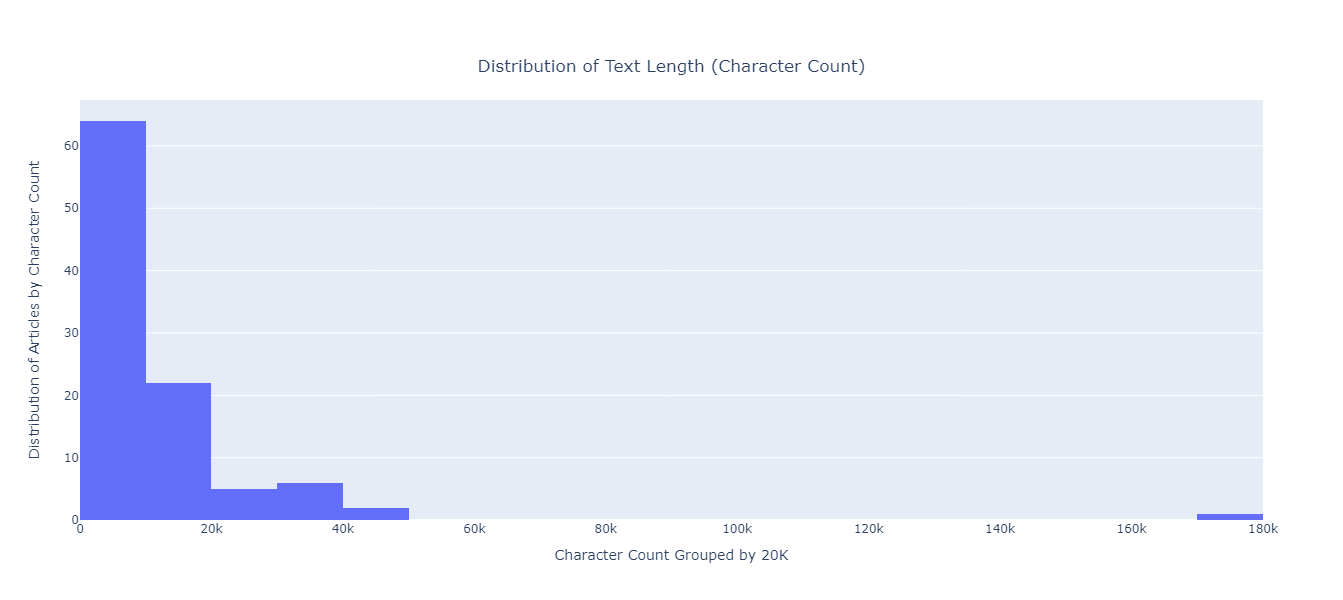

In [13]:
# creating a histogram using plotly to visualize character count
fig = px.histogram( x = train_df["character count"],                    # passing character count on the x-axis
                   title="Distribution of Text Length (Character Count)",     # editing the title of the graph
                   height = 600,                                              # adjusting height
                   labels = dict(x = "Character Count Grouped by 20K"))       # adding a label to the x-axis

fig.update_yaxes(title_text = "Distribution of Articles by Character Count")  # editing the y-axis title

fig.update_layout(title = {'y' : 0.9, 'x' : 0.5})  # ensuring that the title is centred

### Character Count Takeaways

+ There is only one article that has over 50K characters
+ 86% of articles fall under 20K articles 

### Next

+ This is useful information, but there is more that is needed to explore
+ Understanding average words per article, as well as unique words is needed

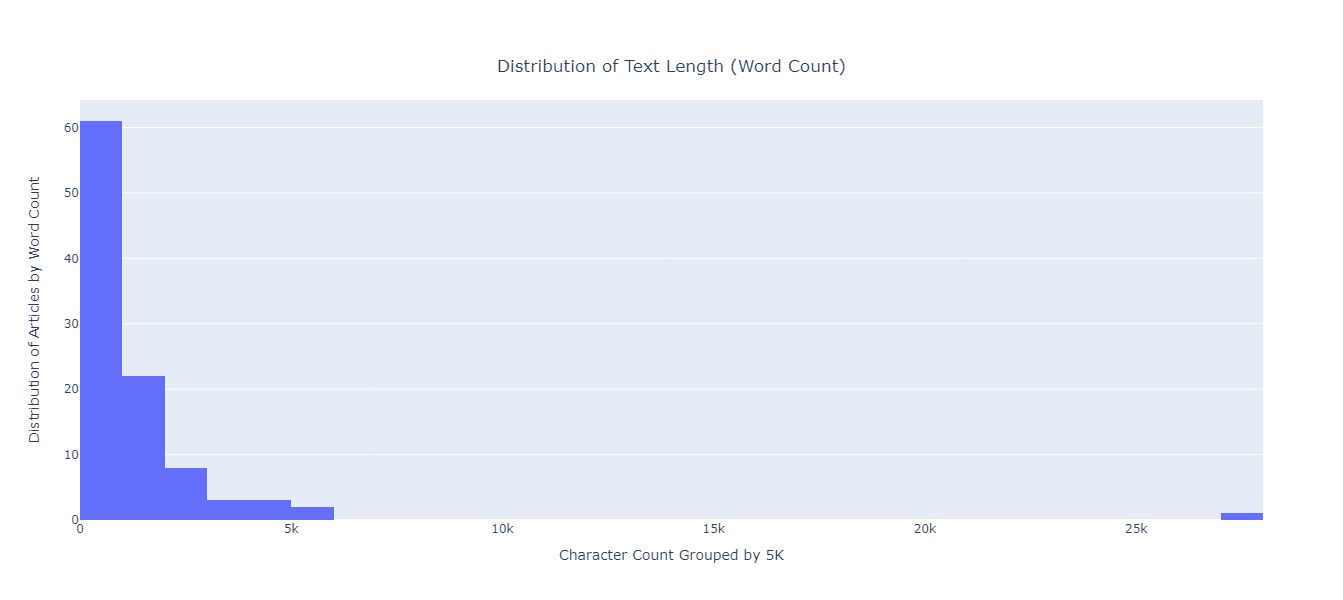

In [14]:
# creating a histogram using plotly to visualize character count
fig = px.histogram( x = train_df["word count"],                    # passing character count on the x-axis
                   title = "Distribution of Text Length (Word Count)",     # editing the title of the graph
                   height = 600,                                              # adjusting height
                   labels = dict(x = "Character Count Grouped by 5K"))       # adding a label to the x-axis

fig.update_yaxes(title_text = "Distribution of Articles by Word Count")  # editing the y-axis title

fig.update_layout(title = {'y' : 0.9, 'x' : 0.5})  # ensuring that the title is centred

### Word Count Takeaway

+ It looks as if only one article has more than 25,000 words
+ While the rest of the articles are under 6,000
+ To have a concrete answer, I will calculate the total number of articles under 6,000 words and divide it by total articles in the dataframe

In [15]:
# calculating  the percentage of articles with 6000 words or less

round(train_df[train_df['word count'] <= 6000]['word count'].count() / len(train_df) * 100, 2)

99.0

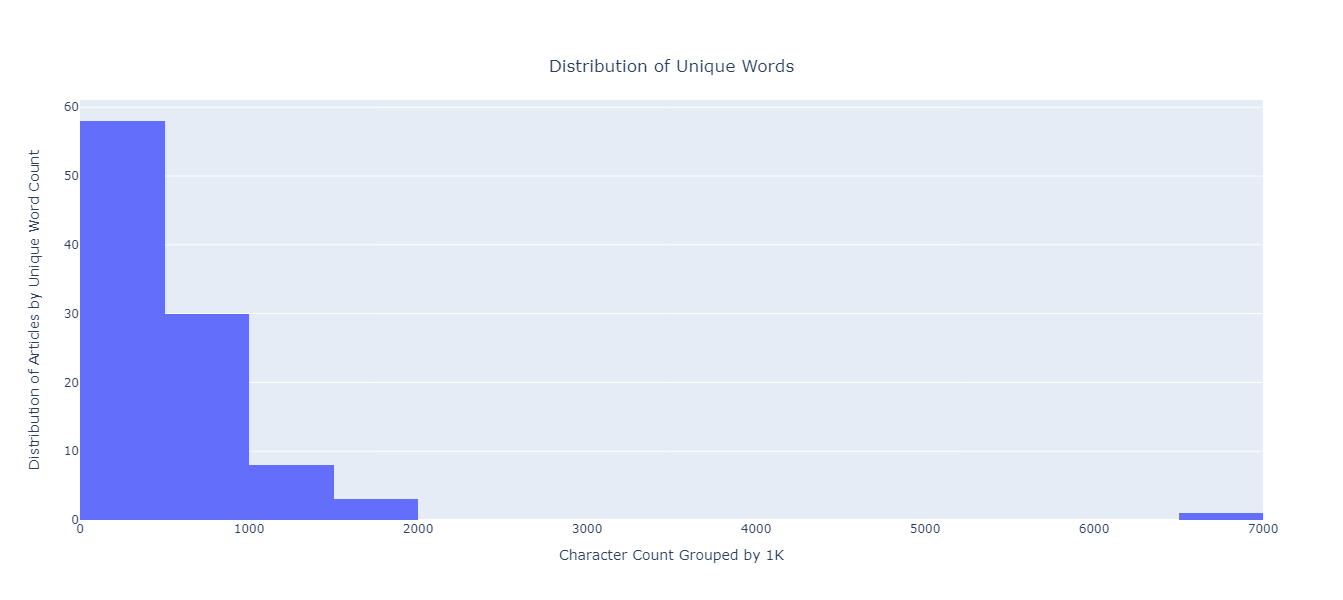

In [16]:
# creating a histogram using plotly to visualize character count
fig = px.histogram( x = train_df["unique word count"],                    # passing character count on the x-axis
                   title="Distribution of Unique Words",     # editing the title of the graph
                   height = 600,                                              # adjusting height
                   labels = dict(x = "Character Count Grouped by 1K"))       # adding a label to the x-axis

fig.update_yaxes(title_text = "Distribution of Articles by Unique Word Count")  # editing the y-axis title

fig.update_layout(title = {'y' : 0.9, 'x' : 0.5})  # ensuring that the title is centred

### Word Count Takeaway

+ It looks as if only one article has more than 7,000 words
+ While the rest of the articles are under 2,000
+ This has a very similar pattern to the two graphs above and it is likely that one article that is an outlier

## Next Steps

### Data Modelling

+ Build a Neural Network that will be able to consume the pre-processed text and output a label
+ For this task specifically, we will use a Siamese Network
+ Siamese network was chosen because it can address the class imbalance and small data set sizes

In [17]:
import random
import numpy as np
import tensorflow as tf

# wherever possible, for reproducibility of results
np.random.seed(42)
tf.random.set_seed(seed = 42)

In [18]:
# counting the labels to understand the distribution of labels and to size the imbalance
train_df['label'].value_counts().reset_index()

,index,label
0,2,59
1,1,32
2,3,9


### A Siamese Network can fit the task well

+  There is an imbalance on the labels side
+ There are 59 documents for  label 2, 32 documents for label 1 and only 9 documents for label 3)

### Data Generators

+ Define a 'Pair' class that is used to generate batches of data pairs for a siamese network
+ The 'Pair' class divides the data into anchor and negative groups for each class
+ Where the anchor consists of the positive instances for a class and the negative group consists of the instances for all other classes
+ The __getitem__ method of the class returns a batch of data pairs and their targets
+ For each batch, it generates data pairs consisting of an anchor instance and a positive instance from the same class, and an anchor instance and a negative instance from a different class
+ The get_support_set method returns a dictionary of sample sets of certain sizes for each target class, which is used to pass the input text multiple times through the model to provide a stable estimate 
+ The generated data pairs and their targets are returned as a numpy array and a tensorflow tensor, respectively

In [19]:
class Pair(tf.keras.utils.Sequence):
    def __init__(self, dataframe: pd.DataFrame, labels: pd.Series, n_batch: int, batch_size: int):
        """Initialize Pair class with required parameters"""
        
        # Store input data and labels
        self.dataframe = dataframe
        self.labels = labels
        
        # Define the number of batches and batch size
        self.n_batch = n_batch
        self.batch_size = batch_size
        
        # Find all unique classes in the input data
        self.all_classes = set(self.labels)
        
        # Divide the data into anchor and negative groups for each class
        self.anchor_groups = {}
        for target_class in self.all_classes:
            self.anchor_groups[target_class] = {
                "positive": self.dataframe[self.labels == target_class],
                "negative": self.dataframe[self.labels != target_class]
            }

    def __len__(self):
        """Returns the number of batches"""
        return self.n_batch

    def __getitem__(self, item):
        """Returns a batch of data pairs and their targets"""
        pairs = []
        
        # Generate data pairs for the batch
        for i in range(int(self.batch_size / 2)):
            anchor_class = random.randint(1, 3)
            anchor_group = self.anchor_groups[anchor_class]["positive"]
            not_anchor_group = self.anchor_groups[anchor_class]["negative"]

            anchor = anchor_group.sample(n=1).iloc[0]
            positive = anchor_group.sample(n=1).iloc[0]
            negative = not_anchor_group.sample(n=1).iloc[0]

            pairs.append([anchor, positive, 1])
            pairs.append([anchor, negative, 0])

        # Shuffle the pairs and convert them to numpy array
        random.shuffle(x=pairs)
        pairs = np.array(pairs)

        # Get data pairs and their targets
        data_pairs = pairs[:, :2]
        targets = pairs[:, 2]

        # Convert targets to tensorflow tensor and return data pairs and targets
        return data_pairs, tf.convert_to_tensor(targets, dtype=np.float32)

    def get_support_set(self, sample_size: int = 1):
        """Returns sample sets of certain size of each target class"""
        support_set = {}
        for target_class in self.all_classes:
            support_set[target_class] = self.anchor_groups[target_class]["positive"].sample(n=sample_size)
        return support_set

## Building a Siamese Neural Network

### What is a Siamese Neural Network?

+ A neural network that learns to compare and measure the similarity of inputs
+ It uses a TextVectorization layer to convert text inputs into numeric vectors
+ Encodes the vectors using a multilayer perceptron
+ The Neural Network is then trained to minimize the distance between vectors of the same class and maximize the distance between vectors of different classes

In [20]:
class SiameseNetwork(tf.keras.Model):
    def __init__(self, corpora: pd.Series):
        super(SiameseNetwork, self).__init__()
        
        # Define the TextVectorization layer for the input
        self.vectorizer_layer: tf.keras.layers.TextVectorization = tf.keras.layers.TextVectorization(
            max_tokens=2000,  # Maximum number of unique tokens in the vocabulary
            output_mode="int",  # Output integers instead of one-hot encoding
            output_sequence_length=512  # Length of the output sequence
        )
        
        # Adapt the TextVectorization layer to the corpus of input data
        self.vectorizer_layer.adapt(corpora.values)
        
        # Define the neural network encoder layers
        self.encoder = tf.keras.Sequential(layers=[
            self.vectorizer_layer,
            tf.keras.layers.Dense(units=256, activation=tf.keras.activations.relu),
            tf.keras.layers.Dropout(rate=0.3),
            tf.keras.layers.Dense(units=128, activation=tf.keras.activations.relu),
            tf.keras.layers.Dropout(rate=0.3),
            tf.keras.layers.Dense(units=64, activation=tf.keras.activations.relu),
            tf.keras.layers.Lambda(function=lambda x: tf.math.l2_normalize(x, axis=1))
        ])
        
        # Define the distance layer between the encoded inputs
        self.encoding_distance = tf.keras.layers.Dot(axes=1)

    def __call__(self, inputs, *args, **kwargs):
        # Split the inputs into anchors and supports
        anchors, supports = inputs[:, 0], inputs[:, 1]
        
        # Encode the anchors and supports using the encoder neural network
        anchors_encoded = self.encoder(anchors)
        supports_encoded = self.encoder(supports)
        
        # Compute the distance between the encoded anchors and supports
        return self.encoding_distance((anchors_encoded, supports_encoded))

    def predict_with_support_set(self, entry, support_set: dict):
        """
        Custom method that wraps around the __call__ method.
        It is used to pass the entry (input text) multiple times
        through the model to average out the losses and provide more
        stable estimate.
        """
        # Compute the mean distance between the input entry and the support set for each class
        scores = {}
        for instance_class, texts in support_set.items():
            class_scores = ([self(np.array([entry, text]).reshape((-1, 2))) for text in texts])
            scores[instance_class] = tf.math.reduce_mean(class_scores)
        
        # Return the class with the highest mean distance score
        return max(scores, key=scores.get)

In [21]:
model = SiameseNetwork(corpora = train_df['preprocessed_text'])

In [22]:
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = 'binary_accuracy')

In [23]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(train_df["preprocessed_text"], train_df["label"],
                                                      test_size=0.2,
                                                      random_state=42, 
                                                      stratify=train_df["label"])

In [24]:
# training params
batch_size = 64
n_batch = 100

# we instantiate training and validation data / pair generators
train_gen = Pair(dataframe = X_train, labels = y_train, n_batch = n_batch, batch_size = batch_size)
val_gen = Pair(dataframe = X_val, labels = y_val, n_batch = n_batch, batch_size = batch_size)

In [25]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3)

In [26]:
history = model.fit(
    x = train_gen,
    validation_data = val_gen,
    epochs = 10,
    callbacks = [early_stopping_callback],
    verbose = 1
)

Epoch 1/10
100/100 [==============================] - 11s 103ms/step - loss: 0.1494 - binary_accuracy: 0.9298 - val_loss: 0.9457 - val_binary_accuracy: 0.5720
Epoch 2/10
100/100 [==============================] - 10s 101ms/step - loss: 0.0215 - binary_accuracy: 0.9881 - val_loss: 1.0480 - val_binary_accuracy: 0.5628
Epoch 3/10
100/100 [==============================] - 10s 105ms/step - loss: 0.0224 - binary_accuracy: 0.9883 - val_loss: 0.9650 - val_binary_accuracy: 0.5903
Epoch 4/10
100/100 [==============================] - 10s 100ms/step - loss: 0.0198 - binary_accuracy: 0.9900 - val_loss: 1.0732 - val_binary_accuracy: 0.5659


### Model Evaluation

+ It is time to evaluate the produced model
+ The history object: all training information is stored in the history object that is returned by the model.fit()

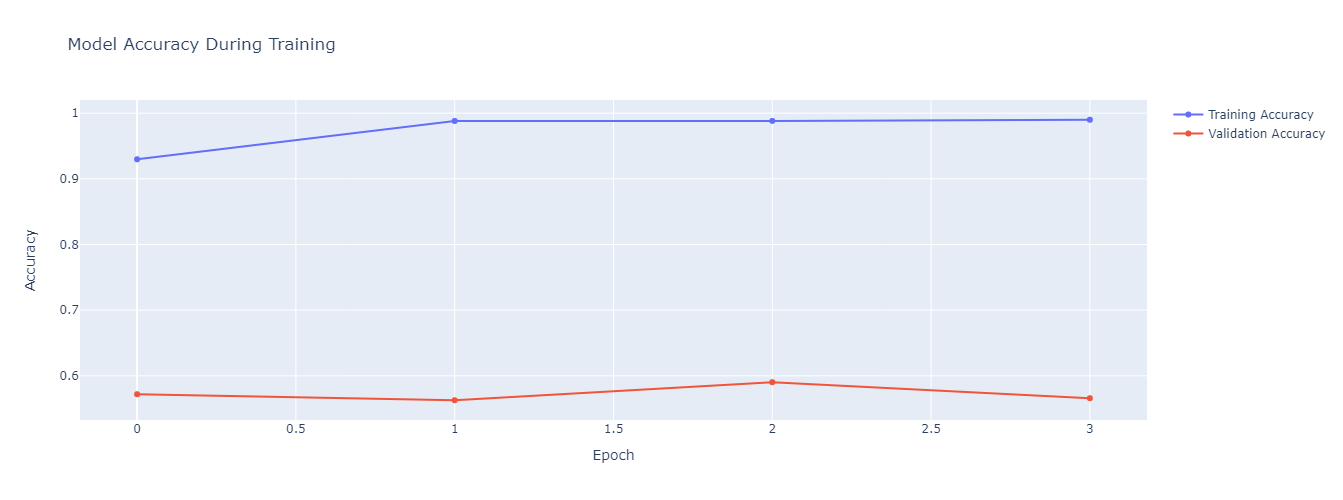

In [27]:
import plotly.graph_objects as go

# creating a new empty figure object using plotly
figure = go.Figure()

# adding a scatter plot of training accuracy to the figure using the history object
figure.add_scatter(y=history.history["binary_accuracy"], name="Training Accuracy")

# adding a scatter plot of validation accuracy to the figure using the history object
figure.add_scatter(y=history.history["val_binary_accuracy"], name="Validation Accuracy")

# updating the layout of the figure with a title and axis labels
figure.update_layout(dict1={
    "title": "Model Accuracy During Training",
    "xaxis_title": "Epoch",
    "yaxis_title": "Accuracy"
}, overwrite=True
 ,width = 1000
 ,height = 500)

# displaying the figure
figure.show()

### Results

+ Training accuracy increases with the number of epochs, while the validation accuracy starts decreasing
+ What does this mean? It is a sign of overfitting
+ How? The training loss decreases then flattens, while the validation fluctuates then begins to decrease
+ Let's look at the training and validations loss in a graph to see if we can arrive at any other assumptions

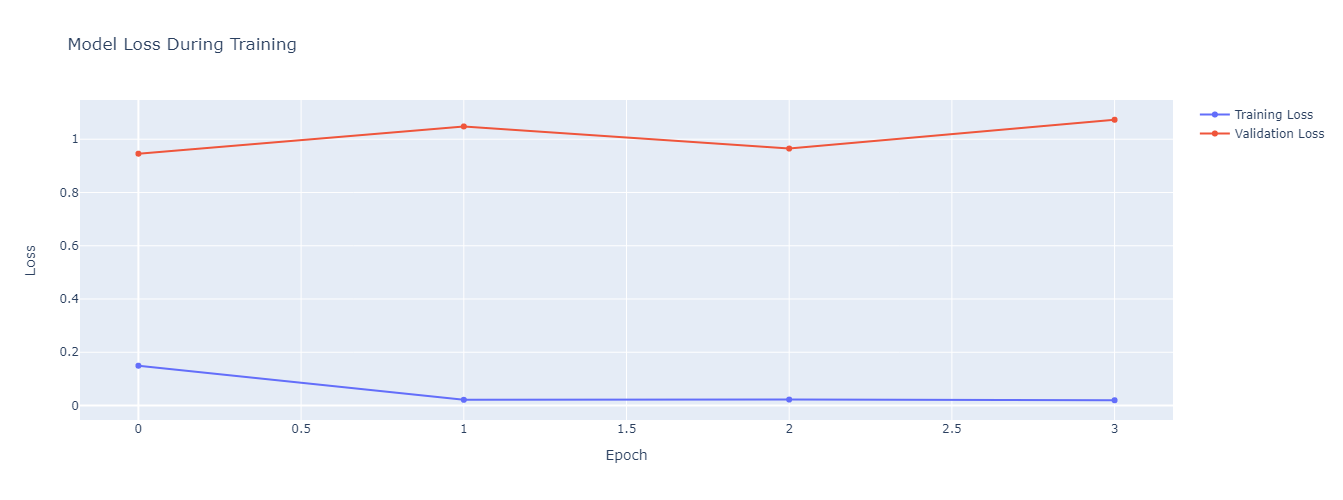

In [28]:
# creating a new empty figure
figure = go.Figure()

# adding a scatter plot of training loss to the figure using the history
figure.add_scatter(y=history.history["loss"], name="Training Loss")

# adding a scatter plot of training loss to the figure using the history
figure.add_scatter(y=history.history["val_loss"], name="Validation Loss")

# updating the layout of the figure with a title and axis labels
figure.update_layout(dict1={
    "title": "Model Loss During Training",
    "xaxis_title": "Epoch",
    "yaxis_title": "Loss"
}, overwrite=True
 ,width = 1000
 ,height = 500)

# This code displays the figure.
figure.show()

### Predictions on the Validation set

+ Since we have used most of the data for training, the validation's metrics are going to be too accurate
+ Why would this happen? Predictions for the model would be used for unseen data, and since validations data was used in training, it will impact the predictions made by the model
+ In general, it is a realistic expectation to see lower accuracy in production setting (but hopefully the model has been trained well enough that it is not too much of a drop)


### Passing the Predictions..

+ Use predict_with_support_set method in the siamese network class
+ The method will pass the entry multiple times through the model with different positive and negative sample to average out its errors
+ The goal: stability when it comes to predictions

In [29]:
y_pred = X_val.apply(lambda text: model.predict_with_support_set(entry = text, support_set = train_gen.get_support_set(7)))

In [30]:
# build a classification report
from sklearn.metrics import classification_report

report = classification_report(y_true = y_val, y_pred = y_pred, zero_division=0)
print(report)

              precision    recall  f1-score   support

           1       0.50      0.67      0.57         6
           2       0.75      0.75      0.75        12
           3       0.00      0.00      0.00         2

    accuracy                           0.65        20
   macro avg       0.42      0.47      0.44        20
weighted avg       0.60      0.65      0.62        20



### Prediction

#### Goal

+ Time to test the model vs. unseen data
+ To predict the correct label on the test csv data

In [31]:
# apply the read_html function to each value in the "doc_id" column of the train_df dataframe
# and store the resulting HTML strings in a new column called "html"
test_df["html"] = test_df["doc_id"].apply(read_html)

In [32]:
# applying the extract html function to the html column
test_df['html_text'] = test_df['html'].apply(extract_html)

In [33]:
# applying function to the html_text column and storing the preprocessed text in a new column
test_df['preprocessed_text'] = test_df['html_text'].apply(preprocess_html_text)

In [34]:
test_df.sample(n = 10, random_state = 42)

,url,doc_id,html,html_text,preprocessed_text
27,http://www.josephstift-dresden.de/pressemittei...,71,"<?xml version=""1.0"" encoding=""utf-8""?>\n<rss v...",\n\nKrankenhaus St. Joseph-Stift Dresden (PM)\...,krankenhaus st joseph stift dresden pm https w...
40,http://www.pius-hospital.de/kliniken/gynaekolo...,123,"<!DOCTYPE html>\n<html lang=""de"" dir=""ltr"" pre...",\n\n\n\n\n\n\n\n\n\n\nPatienteninformationen |...,patienteninformationen klinik fã¼r frauenheilk...
26,http://www.interdisziplinaere-endoskopie.mri.t...,70,"<!DOCTYPE html>\n<html lang=""de"">\n\t<!--[if I...",\n\n\n \n \n\n\nHerzlich Willkommen â Interd...,herzlich willkommen â interdisziplinã endoskop...
43,http://www.uk-augsburg.de/krebsbehandlung/diag...,134,"<!DOCTYPE html> \n<html lang=""de""> \n\t<head> ...",\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nZweitmeinung â...,zweitmeinung â warum ein weiter einschã tzung ...
24,http://www.hjk-muenster.de/unsere-kompetenzen/...,68,"<!DOCTYPE html><html lang=""de"" class=""no-js""><...",GelenkersatzSkip to main contenthjk Die Einric...,gelenkersatzskip main contenthjk die einrichtu...
37,http://www.maria-josef-hospital.de/unsere-komp...,109,"<!DOCTYPE html><html lang=""de"" class=""no-js""><...",Leistungsspektrum BrustzentrumSkip to main con...,leistungsspektrum brustzentrumskip main conten...
12,http://www.ctk.de/klinikum/karriere/stellenang...,46,"<!DOCTYPE html>\n<html lang=""de"">\n<head>\n\n<...",\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nGesundheits-...,gesundheit und krankenpfleg w oder medizinisch...
19,http://www.gesundheitszentrum-wetterau.de/342/...,59,"<!DOCTYPE html>\n<html lang=""de"" dir=""ltr"">\n<...",\n\n\n\n\nMedizinisches Leistungsspektrum wird...,medizinisch leistungsspektrum wird erweitert s...
4,http://marienhospital-buer.de/mhb-av-chirurgie...,16,"<?xml version=""1.0"" encoding=""utf-8""?>\n<!DOCT...",\n\n\n\n\nLeistungsspektrum: Sankt Marien-Hosp...,leistungsspektrum sankt marien hospit buer gmb...
25,http://www.hufeland.de/de/abteilung-fuer-gastr...,69,"<!DOCTYPE html PUBLIC ""-//W3C//DTD XHTML 1.0 T...",\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,such wir ã¼ber un das unternehmen die geschich...


In [36]:
test_df['predictions'] = test_df['preprocessed_text'].apply(lambda text: model.predict_with_support_set(entry = text, support_set = train_gen.get_support_set(7)))

In [37]:
test_df['predictions'].value_counts()

2    37
1    11
Name: predictions, dtype: int64

In [38]:
test_df

,url,doc_id,html,html_text,preprocessed_text,predictions
0,http://chirurgie-goettingen.de/medizinische-ve...,0,"<!doctype html>\n<html lang=""de"" dir=""ltr"">\n\...",\n\n\n\n\n\nBauchspeicheldrÃ¼se | Klinik fÃ¼r ...,bauchspeicheldrã¼s klinik fã¼r allgemein visze...,2
1,http://evkb.de/kliniken-zentren/chirurgie/allg...,2,"<!DOCTYPE html>\n<html lang=""de"" dir=""ltr"" cla...",\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nChirurgi...,chirurgi der bauchspeicheldrã¼s pankreaschirur...,2
2,http://krebszentrum.kreiskliniken-reutlingen.d...,7,"<!DOCTYPE html PUBLIC ""-//W3C//DTD XHTML 1.0 T...",\n\n\nBrustzentrum Reutlingen: Behandlungsverf...,brustzentrum reutlingen behandlungsverfahren k...,2
3,http://marienhospital-buer.de/mhb-av-chirurgie...,15,"<?xml version=""1.0"" encoding=""utf-8""?>\n<!DOCT...",\n\n\n\n\nLeistungsspektrum: Sankt Marien-Hosp...,leistungsspektrum sankt marien hospit buer gmb...,2
4,http://marienhospital-buer.de/mhb-av-chirurgie...,16,"<?xml version=""1.0"" encoding=""utf-8""?>\n<!DOCT...",\n\n\n\n\nLeistungsspektrum: Sankt Marien-Hosp...,leistungsspektrum sankt marien hospit buer gmb...,2
5,http://onkozentrum.med.uni-rostock.de/informat...,24,<!DOCTYPE html>\n<!-- HTML5 Shim and Respond.j...,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nTumorzentrum R...,tumorzentrum rostock e v â onkologisch zentrum...,1
6,http://www.asklepios.com/goslar/experten/haema...,31,"<!DOCTYPE html>\n<html xml:lang=""de"" lang=""de""...",\n\n\nGynÃ¤kologische Tumore - Asklepios Harzk...,gynã kologisch tumor asklepio harzklinik gosla...,1
7,http://www.asklepios.com/hamburg/altona/expert...,32,"<!DOCTYPE html>\n<html xml:lang=""de"" lang=""de""...",\n\n\nInterdisziplinÃ¤re Tumorkonferenzen - As...,interdisziplinã tumorkonferenzen asklepio klin...,1
8,http://www.barmherzige-regensburg.de/herzrhyth...,36,"<!DOCTYPE html>\n<html lang=""de"">\n<head>\n\n<...",\n\n\n\n\n\n\n\n\nSelbsthilfegruppen - Kranken...,selbsthilfegruppen krankenhaus barmherzig brã¼...,1
9,http://www.barmherzige-regensburg.de/zentrum-f...,38,"<!DOCTYPE html>\n<html lang=""de"">\n<head>\n\n<...",\n\n\n\n\n\n\n\n\nStereotaktische Radiotherapi...,stereotaktisch radiotherapi krankenhaus barmhe...,2


In [39]:
train_df['label'].value_counts()

2    59
1    32
3     9
Name: label, dtype: int64

In [40]:
test_df['predictions'].value_counts()

2    37
1    11
Name: predictions, dtype: int64